# Comparing Python Clustering Algorithms
#### (Why you should use HDBSCAN)

There are a lot of clustering algorithms to choose from. The standard `sklearn` clustering suite has thirteen different clustering classes alone. So what clustering algorithms should you be using? As with every question in data science and machine learning it depends on your data. A number of those thirteen classes in `sklearn` are specialised for certain tasks (such as co-clustering and bi-clustering, or clustering features instead data points). Obviously an algorithm specializing in text clustering is going to be the right choice for clustering text data, and other algorithms specialize in other specific kinds of data. Thus, if you know enough about your data, you can narrow down on the clustering algorithm that best suits that kind of data, or the sorts of important properties your data has, or the sorts of clustering you need done. All well and good, but what if you don't know much about your data? If, for example, you are 'just looking' and doing some exploratory data analysis (EDA) it is not so easy to choose a specialized algorithm. So, what algorithm is good for exploratory data analysis?

### Some rules for EDA clustering

To start, lets' lay down some ground rules of what we need a good EDA clustering algorithm to do, then we can set about seeing how the algorithms available stack up.

* **Don't be wrong!**: If you are doing EDA you are trying to learn and gain intuitions about your data. In that case it is far better to get no result at all than a result that is wrong. Bad results lead to false intuitions which in turn send you down completely the wrong path. Not only do you not understand your data, you *misunderstand* your data. This means a good EDA clustering algorithm needs to conservative in int's clustering; it should be willing to not assign points to clusters; it should not group points together unless they really are in a cluster; this is true of far fewer algorithms than you might think.
* **Intuitive Parameters**: All clustering algorithms have parameters; you need some knobs to turn to adjust things. The question is: how do you pick settings for those parameters? If you know little about your data it can be hard to determine what value or setting a parameter should have. This means parameters need to be intuitive enough that you can hopefully set them without having to know a lot about your data.
* **Stable Clusters**: If you run the algorithm twice with a different random initialization, you should expect to get roughly the same clusters back. If you are sampling your data, taking a different random sample shouldn't radically change the resulting cluster structure (unless your sampling has problems). If you vary the clustering algorithm parameters you want the clustering to change in a somewhat stable predictable fashion.
* **Performance**: Data sets are only getting bigger. You can sub-sample (but see *stability*), but ultimately you need a clustering algorithm that can scale to large data sizes. A clustering algorithm isn't much use if you can only use it if you take such a small sub-sample that it is no longer representative of the data at large!

There are other nice to have features like soft clusters, or overlapping clusters, but the above desiderata is enough to get started with because, oddly enough, very few clustering algorithms can satisfy them all!

## Getting set up

If we are going to compare clustering algorithms we'll need a few things; first some libraries to load and cluster the data, and second some visualisation tools so we can look at the results of clustering. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

Next we need some data. In order to make this more interesting I've constructed an artificial dataset that will give clustering algorithms a challenge -- some non-globular clusters, some noise etc.; the sorts of things we expect to crop up in messy real-world data. So that we can actually visualize clusterings the dataset is two dimensional; this is not something we expect from real-world data where you generally can't just visualize and see what is going on.

In [2]:
data = np.load('clusterable_data.npy')

So let's have a look at the data and see what we have.

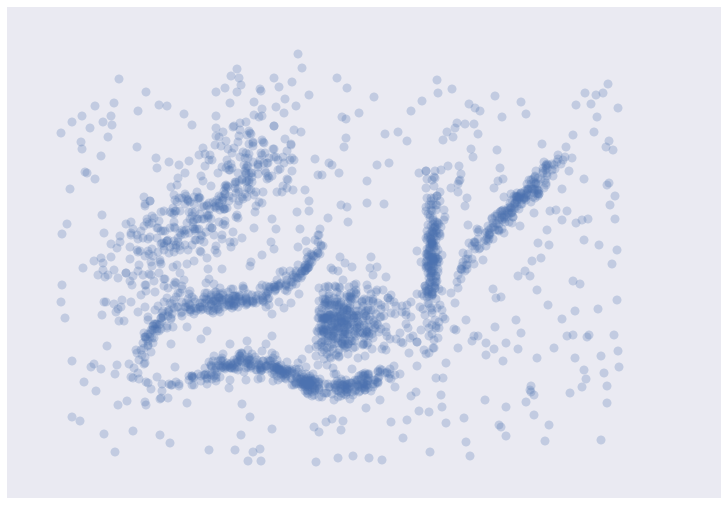

In [3]:
plt.scatter(data.T[0], data.T[1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

It's messy, but there are certainly some clusters that you can pick out by eye; determining the exact boundaries of those clusters is harder of course, but we can hope that our clustering algorithms will find at least some of those clusters. So, on to testing ...

## Testing Clustering Algorithms

To start let's set up a little utility function to do the clustering and plot the results for us. We can time the clustering algorithm while we're at it and add that to the plot since we do care about performance.

In [4]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

Before we try doing the clustering, there are some things to keep in mind as we look at the results.

* In real use cases we *can't* look at the data and realise points are not really in a cluster; we have to take the clustering algorithm at its word.
* This is a small dataset, so poor performance here bodes very badly.

On to the clustering algorithms.

## K-Means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). K-Means has a few problems however. The first is that it isn't a clustering algorithm, it is a partitioning algorithm. That is to say K-means doesn't 'find clusters' it partitions your dataset into as many (assumed to be globular) chunks as you ask for by attempting to minimize intra-partition distances. That leads to the second problem: you need to specify exactly how many clusters you expect. If you know a lot about your data then that is something you might expect to know. If, on the other hand, you are simply exploring a new dataset then 'number of clusters' is a hard parameter to have any good intuition for. The usually proposed solution is to run K-Means for many different 'number of clusters' values and score each clustering with some 'cluster goodness' measure (usually a variation on intra-cluster vs inter-cluster distances) and attempt to find an 'elbow'. If you've ever done this in practice you know that finding said elbow is usually not so easy, nor does it necessarily correlate as well with the actual 'natural' number of clusters as you might like. Finally K-Means is also dependent upon initialization; give it multiple different random starts and you can get multiple different clusterings. This does not engender much confidence in any individual clustering that may result.

So, in summary, here's how K-Means seems to stack up against out desiderata:
* **Don't be wrong!**: K-means is going to throw points into clusters whether they belong or not; it also assumes you clusters are globular. K-Means scores very poorly on this point.
* **Intuitive parameters**: If you have a good intuition for how many clusters the dataset your exploring has then great, otherwise you might have a problem.
* **Stability**: Hopefully the clustering is stable for your data. Best to have many runs and check though.
* **Performance**: This is K-Means big win. It's a simple algorithm and with the right tricks and optimizations can be made exceptionally efficient. There are few algorithms that can compete with K-Means for performance. If you have truly huge data then K-Means might be your only option.

But enough opinion, how does K-Means perform on our test dataset? Let's have look. We'll be generous and use our knowledge that there are six natural clusters and give that to K-Means.

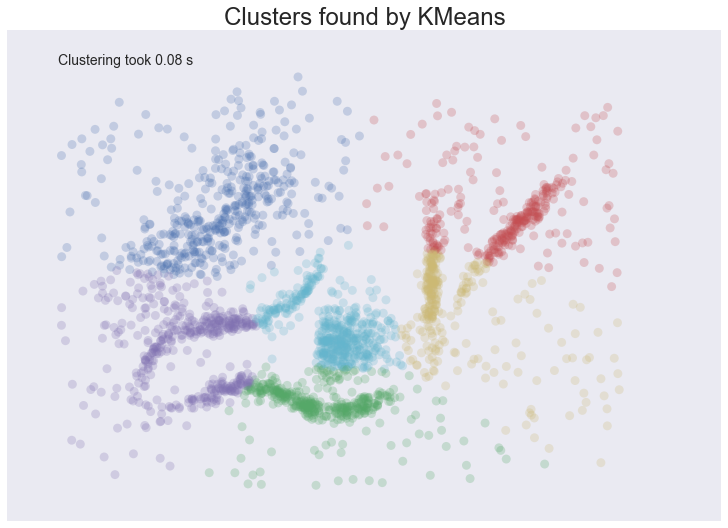

In [5]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters':6})

We see some interesting results. First, the assumption of perfectly globular clusters means that the natural clusters have been spliced and clumped into various more globular shapes. Worse, the noise points get lumped into clusters as well: in some cases, due to where relative cluster centers ended up, points very distant from a cluster get lumped in. Having noise pollute your clusters like this is particularly bad in an EDA world since they can easily mislead your intuition and understanding of the data. On a more positive note we completed clustering very quickly indeed, so at least we can be wrong quickly.

## Affinity Propagation

Affinity Propagation is a newer clustering algorithm that uses a graph based approach to let points 'vote' on their preferred 'exemplar'. The end result is a set of cluster 'exemplars' from which we derive clusters by essentially doing what K-Means does and assigning each point to the cluster of it's nearest exemplar. Affinity Propagation has some advantages over K-Means. First of all the graph based exemplar voting means that the user doesn't need to specify the number of clusters. Second, due to how the algorithm works under the hood with the graph representation it allows for non-metric dissimilarities (i.e. we can have dissimilarities that don't obey the triangle inequality, or aren't symmetric). This second point is important if you are ever working with data isn't naturally embedded in a metric space of some kind; few clustering algorithms support, for example, non-symmetric dissimilarities. Finally Affinity Propagation does, at least, have better stability over runs (but not over parameter ranges!).

The weak points of Affinity Propagation are similar to K-Means. Since it partitions the data just like K-Means we expect to see the same sorts of problems, particularly with noisy data. While Affinity Propagation eliminates the need to specify the number of clusters, it has 'preference' and 'damping' parameters. Picking these parameters well can be difficult. The implementation in `sklearn` default preference to the median dissimilarity. This tends to result in a very large number of clusters. A better value is something smaller (or negative) but data dependent. Finally Affinity Propagation is *slow*; since it supports non-metric dissimilarities it can't take any of the shortcuts available to other algorithms, and the basic operations are expensive as data size grows.

So, in summary, over our desiderata we have:

* **Don't be wrong**: The same issues as K-Means; Affinity Propagation is going to throw points into clusters whether they belong or not; it also assumes you clusters are globular.
* **Intuitive Parameters**: It can be easier to guess at preference and damping than number of clusters, but since Affinity Propagation is quite sensitive to preference values it can be fiddly to get "right". This isn't really that much of an improvement over K-Means.
* **Stability**: Affinity Propagation is deterministic over runs.
* **Performance**: Affinity Propagation tends to be very slow. In practice running it on large datasets is essentially impossible without a carefully crafted and optimized implementation (i.e. not the default one available in `sklearn`).

And how does it look in practice on our chosen dataset? I've tried to select a preference and damping value that gives a reasonable number of clusters (in this case six) but feel free to play with the parameters yourself and see if you can come up with a better clustering.

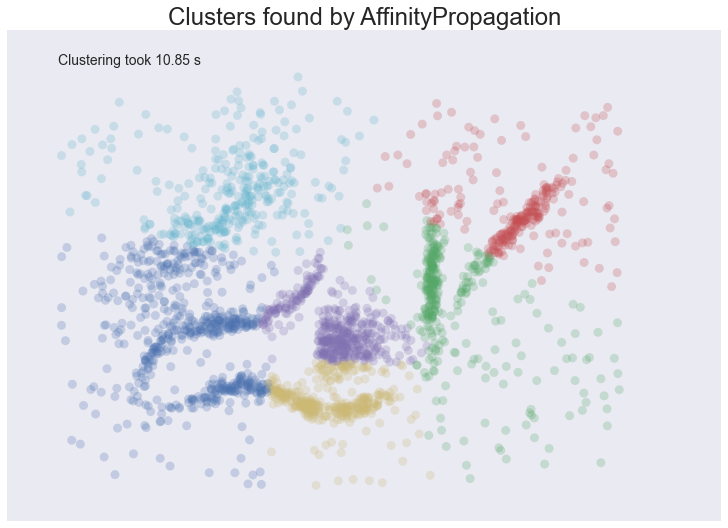

In [6]:
plot_clusters(data, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

The result is eerily similar to K-Means and has all the same problems. The globular clusters have lumped together splied parts of various 'natural' clusters. The noise points have been assigned to clusters regardless of being significant outliers. In other words, we'll have a very poor intuitive understanding of our data based on these 'clusters'. Worse still it took us several seconds to arrive at this unenlightening conclusion.

## Mean Shift

Mean shift is another option if you don't want to have to specify the number of clusters. It is centroid based, like K-Means and affinity propagation, but can return clusters instead of a partition. The underlying idea of the Mean Shift algorithm is that there exists some probability density function from which the data is drawn, and tries to place centroids of clusters at the maxima of that density function. It approximates this via kernel density estimation techniques, and the key parameter is then the bandwidth of the kernel used. This is easier to guess than the number of clusters, but may require some staring at, say, the distributions of pairwise distances between data points to choose successfully. The other issue (at least with the sklearn implementation) is that it is fairly slow depsite potentially having good scaling!

How does Mean Shift fare against out criteria? In principle proming, but in practice ...

* **Don't be wrong!**: Mean Shift doesn't cluster every point, but it still aims for globular clusters, and in practice it can return less than ideal results (see below for example). Without visual validation it can be hard to know how wrong it may be.
* **Intuitive parameters**: Mean Shift has more intuitive and meaningful parameters; this is certainly a strength.
* **Stability**: Mean Shift results can vary a lot as you vary the bandwidth parameter (which can make selection more difficult than it first appears. It also has a random initialisation, which means stability under runs can vary (if you reseed the random start).
* **Performance**: While Mean Shift has good scalability in principle (using ball trees) in practice the sklearn implementation is slow; this is a serious weak point for Mean Shift.

Let's see how it works on some actual data. I spent a while trying to find a good bandwidth value that resulted in a reasonable clustering. The choice below is about the best I found.

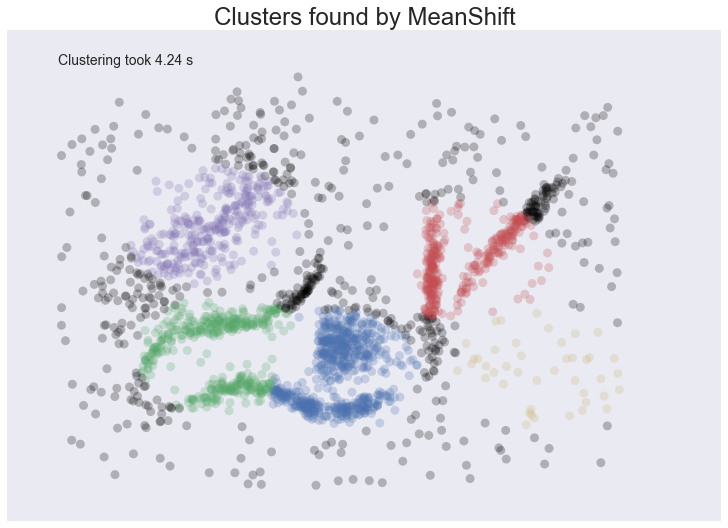

In [7]:
plot_clusters(data, cluster.MeanShift, (0.175,), {'cluster_all':False})

We at least aren't polluting our clusters with as much noise, but we certainly have dense regions left as noise and clusters that run across and split what seem like natural clusters. There is also the outlying yellow cluster group that doesn't make a lot of sense. Thus while Mean Shift had good promise, and is certainly better than K-Means, it's still short of our desiderata. Worse still it took over 4 seconds to cluster this small dataset!

## Spectral Clustering

Spectral clustering can best be thought of as a graph clustering. For spatial data one can think of inducing a graph based on the distances between points (potentially a k-NN graph, or even a dense graph). From there spectral clustering will look at the eigenvectors of the Laplacian of the graph to attempt to find a good (low dimensional) embedding of the graph into Euclidean space. This is essentially a kind of manifold learning, finding a transformation of our original space so as to better represent manifold distances for some manifold that the data is assumed to lie on. Once we have the transformed space a standard clustering algorithm is run; with `sklearn` the default is K-Means. That means that the key for spectral clustering is the transformation of the space. Presuming we can better respect the manifold we'll get a better clustering -- we need worry less about K-Means globular clusters as they are merely globular on the transformed space and not the original space. We unfortunately retain some of K-Means weaknesses: we still partition the data instead of clustering it; we have the hard to guess 'number of clusters' parameter; we have stability issues inherited from K-Means. Worse, if we operate on the dense graph of the distance matrix we have a very expensive initial step and sacrifice performance.

So, in summary:

* **Don't be wrong!**: We are less wrong, in that we don't have a purely globular cluster assumption; we do still have partitioning and hence are polluting clusters with noise, messing with our understanding of the clusters and hence the data.
* **Intuitive parameters**: We are no better than K-Means here; we have to know the correct number of clusters, or hope to guess by clustering over a range of parameter values and finding some way to pick the 'right one'.
* **Stability**: Slightly more stable than K-Means due to the transformation, but we still suffer from those issues.
* **Performance**: For spatial data we don't have a sparse graph (unless we prep one ourselves) so the result is a somewhat slower algorithm.

Let's have a look at how it operates on our test dataset. Again, we'll be generous and give it the six clusters to look for.

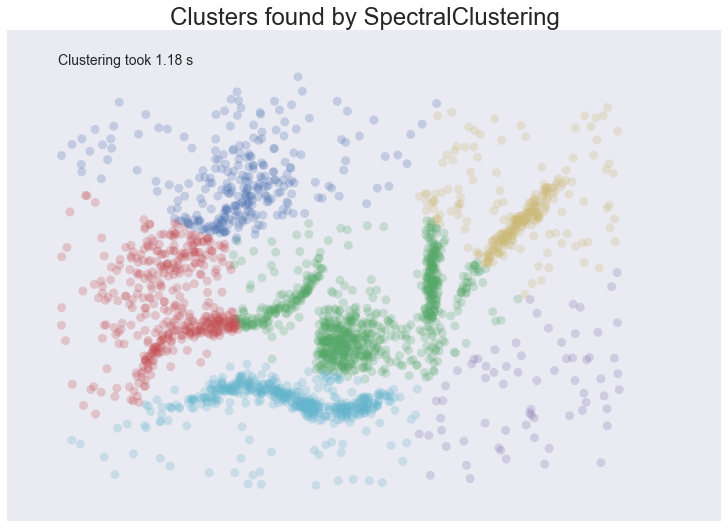

In [8]:
plot_clusters(data, cluster.SpectralClustering, (), {'n_clusters':6})

Spectral clustering performed *better* on the long thin clusters, but still ended up cutting some of them strangely and dumping parts of them in with other clusters. We also still have the issue of noise points polluting our clusters, so again our intuitions are going to be led astray. Performance was a distinct improvement of Affinity Propagation however. Over all we are doing better, but are still a long way from achieving our desiderata.

## Agglomerative Clustering

Agglomerative clustering is really a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split. More complex variations use things like mean distance between clusters, or distance between cluster centroids etc. to determine which cluster to merge. Once you have a cluster hierarchy you can choose a level or cut (according to some criteria) and take the clusters at that level of the tree. For `sklearn` we usually choose a cut based on a 'number of clusters' parameter passed in.

The advantage of this approach is that clusters can grow 'following the underlying manifold' rather than being presumed to be globular. You can also inspect the dendrogram of clusters and get more information about how clusters break down. On the other hand, if you want a flat set of clusters you need to choose a cut of the dendrogram, and that can be hard to determine. You can take the `sklearn` approach and specify a number of clusters, but as we've already discussed that isn't a particularly intuitive parameter when you're doing EDA. You can look at the dendrogram and try to pick a natural cut, but this is similar to finding the 'elbow' across varying `k` values for K-Means: in principle it's fine, and the textbook examples always make it look easy, but in practice on messy real world data the 'obvious' choice is often far from obvious. We are also still partitioning rather than clustering the data, so we still have that persistent issue of noise polluting our clusters. Fortunately performance can be pretty good; the `sklearn` implementation is fairly slow, but [`fastcluster`](https://pypi.python.org/pypi/fastcluster) provides high performance agglomerative clustering if that's what you need.

So, in summary:

* **Don't be wrong!**: We have gotten rid of the globular assumption, but we are still assuming that all the data belongs in clusters with no noise.
* **Intuitive parameters**: Similar to K-Means we are stuck choosing the number of clusters (not easy in EDA), or trying to discern some natural parameter value from a plot that may or may not have any obvious natural choices.
* **Stability**: Agglomerative clustering is stable across runs and the dendrogram shows how it varies over parameter choices (in a reasonably stable way), so stability is a strong point.
* **Performance**: Performance can be good if you get the right implementation.

So, let's see it clustering data. I chose to provide the correct number of clusters (six) and use Ward as the linkage/merge method. This is a more robust method than say single linkage, but it does tend toward more globular clusters.

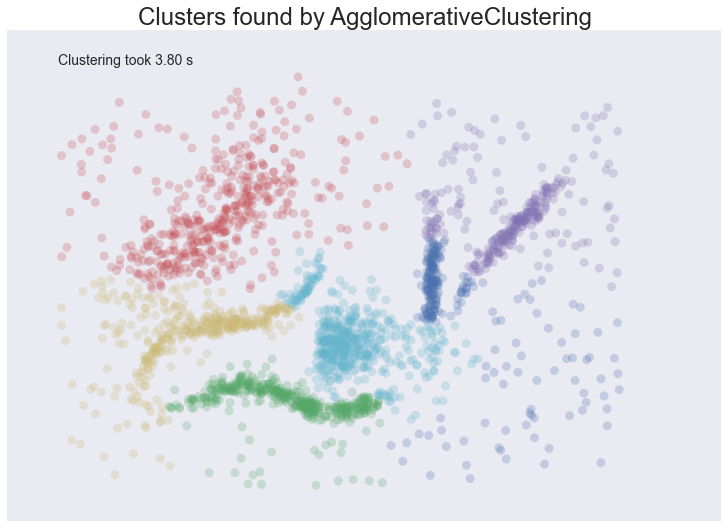

In [9]:
plot_clusters(data, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

Similar to the spectral clustering we have handled the long thin clusters much better than K-Means or Affinity Propagation. We in fact improved on spectral clustering a bit on that front. We do still have clusters that contain parts of several different natural clusters, but those 'mis-clusterings' are smaller. We also still have all the noise points polluting our clusters. The end result is probably the best clustering we've seen so far, but given the mis-clustering and noise issues we are still not going to get as good an intuition for the data as we might reasonably hope for.

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. This provides several advantages: we get the manifold following behaviour of agglomerative clustering, and we get actual clustering as opposed to partitioning. Better yet, since we can frame the algorithm in terms of local region queries we can use various tricks such as kdtrees to get exceptionally good performance and scale to dataset sizes that are otherwise unapproachable with algorithms other than K-Means. There are some catches however. Obviously epsilon can be hard to pick; you can do some data analysis and get a good guess, but the algorithm can be quite sensitive to the choice of the parameter. The density based transformation depends on another parameter (`min_samples` in `sklearn`). Finally the combination of `min_samples` and `eps` amounts to a choice of density and the clustering only finds clusters at or above that density; if your data has variable density clusters then DBSCAN is either going to miss them, split them up, or lump some of them together depending on your parameter choices.

So, in summary:

* **Don't be wrong!**: Clusters don't need to be globular, and won't have noise lumped in; varying density clusters may cause problems, but that is more in the form of insufficient detail rather than explicitly wrong. DBSCAN is the first clustering algorithm we've looked at that actually meets the 'Don't be wrong!' requirement.
* **Intuitive parameters**: Epsilon is a distance value, so you can survey the distribution of distances in your dataset to attempt to get an idea of where it should lie. In practice, however, this isn't an especially intuitive parameter, nor is it easy to get right.
* **Stability**: DBSCAN is stable across runs (and to some extent subsampling if you re-parameterize well); stability over varying epsilon and min samples is not so good.
* **Performance**: This is DBSCAN's other great strength; few clustering algorithms can tackle datasets as large as DBSCAN can.

So how does it cluster our test dataset? I played with a few epsilon values until I got somethign reasonable, but there was little science to this -- getting the parameters right can be hard.

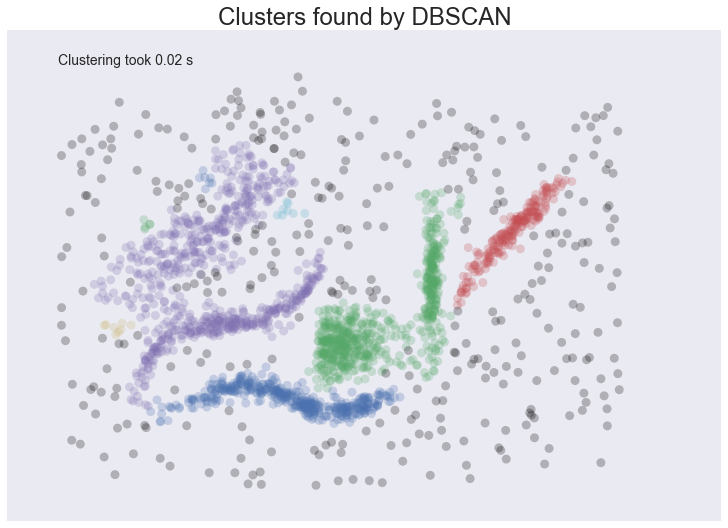

In [10]:
plot_clusters(data, cluster.DBSCAN, (), {'eps':0.025})

This is a pretty decent clustering; we've lumped natural clusters together a couple of times, but at least we didn't carve them up to do so. We also picked up a few tiny clusters in amongst the large sparse cluster. These problems are artifacts of not handling variable density clusters -- to get the sparser clusters to cluster we end up lumping some of the denser clusters with them; in the meantime the very sparse cluster is still broken up into several clusters. All in all we're finally doing a decent job, but there's still plenty of room for improvement.

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability. The immediate advantage of this is that we can ave varying density clusters; the second benefit is that we have eliminated the epsilon parameter as we no longer need it to choose a cut of the dendrogram. Instead we have a new parameter `min_cluster_size` which is used to determine whether points are 'falling out of a cluster' or splitting to form two new clusters. This trades an unintuitive parameter for one that is not so hard to choose for EDA (what is the minimum size cluster I am willing to care about?).

So, in summary:

* **Don't be wrong!**: We inherited all the benefits of DBSCAN and removed the varying density clusters issue. HDBSCAN is easily the strongest option on the 'Don't be wrong!' front.
* **Intuitive parameters**: Choosing a mimnimum cluster size is very reasonable. The only remaining parameter is `min_samples` inherited from DBSCAN for the density based space transformation. Sadly `min_samples` is not that intuitive; HDBSCAN is not that sensitive to it and we can choose some sensible defaults, but this remains the biggest weakness of the algorithm.
* **Stability**: HDBSCAN is stable over runs and subsampling (since the variable density clustering will still cluster sparser subsampled clusters with the same parameter choices), and has good stability over parameter choices.
* **Performance**: When implemented well HDBSCAN can be very efficient. The current implementation has similar performance to `fastcluster`'s agglomerative clustering (and will use `fastcluster` if it is available), but we expect future implementations that take advantage of newer data structure such as cover trees to scale significantly better.

How does HDBSCAN perform on our test dataset? Unfortunately HDBSCAN is not part of `sklearn`. Fortunately we can just import the [hdbscan library](https://github.com/scikit-learn-contrib/hdbscan) and use it as if it were part of `sklearn`.

In [11]:
import hdbscan

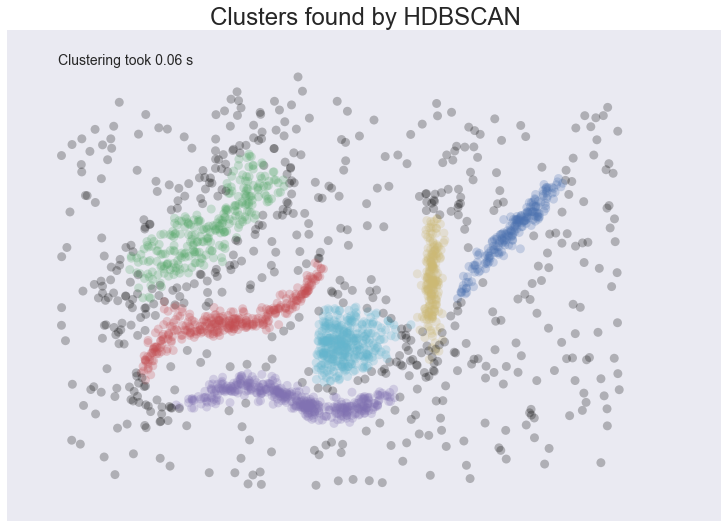

In [12]:
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':15})

I think the picture speaks for itself.